In [1]:
%matplotlib inline
import plot_helpers as ph
from matplotlib import pyplot as plt

In [12]:
fairgp_files_race = [
    ('../results/ICML/propublica/gpyt500_eqopp_tuning_race.csv', 'ProPublica (race)'),
]
def label_change(label):
    parts = label.split('_')
    #mode = parts[-1]
    in_True = parts[4] == "True"
    tnr = parts[6]
    if not in_True and tnr != "0.74":
        return
    if in_True and tnr != "0.71":
        return
    optional_star = "*" if in_True else ""
    with_s = ", use $s$" if in_True else ""
    #return f"FairGPparity{optional_star}", in_True
    #return "average" if mode == "True" else mode, True
    num = label.split('_')[-1]
    return f"$TPR_t={num}${with_s}", not in_True

fairgp_race = ph.parse_all(fairgp_files_race, label_change)

In [13]:
fairgp_files_sex = [
    ('../results/ICML/propublica/gpyt500_eqopp_tuning_sex.csv', 'ProPublica (sex)'),
]
def label_change(label):
    parts = label.split('_')
    #mode = parts[-1]
    in_True = parts[4] == "True"
    tnr = parts[6]
    if not in_True and tnr != "0.77":
        return
    if in_True and tnr != "0.72":
        return
    optional_star = "*" if in_True else ""
    with_s = ", use $s$" if in_True else ""
    #return f"FairGPparity{optional_star}", in_True
    #return "average" if mode == "True" else mode, True
    num = label.split('_')[-1]
    return f"$TPR_t={num}${with_s}", not in_True

fairgp_sex = ph.parse_all(fairgp_files_sex, label_change)

In [14]:
fairgp = fairgp_race + fairgp_sex

In [15]:
baselinegp_files = [
    ('../results/ICML/propublica/gpyt500_baseline_race.csv', ''),
    ('../results/ICML/propublica/gpyt500_baseline_sex.csv', ''),
]
def label_change(label):
    parts = label.split('_')
    #mode = parts[-1]
    in_True = parts[2] == "True"
    if in_True:
        return
    optional_star = "*" if in_True else ""
    with_s = ", use $s$" if in_True else ""
    #return f"FairGPparity{optional_star}", in_True
    #return "average" if mode == "True" else mode, True
    return f"GP{with_s}", not in_True

baselinegp = ph.parse_all(baselinegp_files, label_change)

In [16]:
baseline_files = [
    ('../results/parity_opp_update_2018-08-28/opp_fixed/propublica-recidivism_race_baseline.csv', ''),
    ('../results/parity_opp_update_2018-08-28/opp_fixed/propublica-recidivism_sex_baseline.csv', ''),
]
def label_change(label):
#     algos = [
#         #'ZafarFairness',
#         #'ZafarAccuracy',
#         'ZafarEqOpp',
#         'SVM',
#         #'GP',
#         #'DecisionTree',
#     ]
    if label == 'ZafarEqOpp':
        return 'baseline: Zafar', True
    if label == 'SVM':
        return 'baseline: SVM', True

baselines = ph.parse_all(baseline_files, label_change)

In [17]:
baselines = ph.merge_plot_defs(baselinegp, baselines)

In [18]:
# transform the TPR ratio in the race results so that the bias is in the same direction as the sex results
def inverse(x):
    return 1 / x
fairgp = ph.transform_all(fairgp, 'race-TPRRatio', inverse)
baselines = ph.transform_all(baselines, 'race-TPRRatio', inverse)

In [19]:
fairgp = ph.choose_entries(fairgp, [0, 5, 1, 6, 2, 7, 3, 8])
#baselines = ph.choose_entries(baselines, [1, 0])

In [22]:
def acc_vs_tprr(plot, do_legend, sens, swap_ratio, *data):
    if swap_ratio:
        xaxis = (f'{sens}-TPRRatio', '$TPR_{s=1}\\,/\\,TPR_{s=0}$')
    else:
        xaxis = (f'{sens}-TPRRatio', '$TPR_{s=0}\\,/\\,TPR_{s=1}$')
    yaxis = ('accuracy', 'accuracy')
    legends = []
    startindex = 0
    legend = "outside" if do_legend else None

    plot.axvline(x=1.0, linestyle='--', color='k', label="perfect fairness" if do_legend else None)
    for data_structure in data:
        legends += [ph.errorbox(plot, data_structure, xaxis, yaxis, legend=legend, firstcolor=startindex // 2, firstshape=startindex)]
        startindex += len(data_structure.entries)
    if do_legend:
        return legends

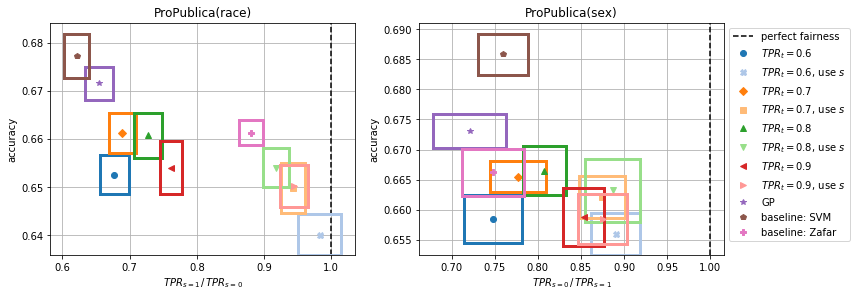

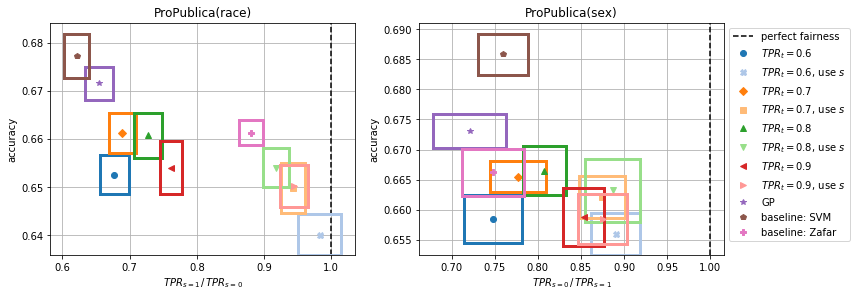

In [23]:
fig, plots = plt.subplots(ncols=2, figsize=(12, 3.6))
acc_vs_tprr(plots[0], False, 'race', True, fairgp[0], baselines[0])
plots[0].set_title("ProPublica(race)")
legends = acc_vs_tprr(plots[1], True, 'sex', False, fairgp[1], baselines[1])
plots[1].set_title("ProPublica(sex)")
#plot.set_ylim(0.785, 0.865)
#plot.set_xlim(0.2, 1.5)

fig.tight_layout()
fig.subplots_adjust(bottom=0)
fig.savefig("eqopp_icml.pdf",
            dpi=200, bbox_extra_artists=legends, bbox_inches='tight', pad_inches=0)
fig